# Sea Ice Zone Data Processing from CESM2-LE
- Process data for Southern Ocean SIZ each year
- Notebook by Alice DuVivier (NCAR)
- Note: this notebook needs to load the utils.py file
- January 2024

## SIZ is the maximum area covered by sea ice in each year

- Satellite observations show maximum sea ice extent in September but CESM2 has maximum in October (DuVivier et al. 2020, https://doi.org/10.1029/2019JC015934). So, we need to check which month to use for CESM2-LE or if we do a mean of both months.

In [1]:
import utils
import xarray as xr
import numpy as np
import dask
from distributed import Client
from ncar_jobqueue import NCARCluster
from glob import glob
import intake
import importlib
import pop_tools
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs

/glade/work/duvivier/miniconda3/envs/analysis3/lib/python3.7/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


## Spin up DASK cluster

In [2]:
# Create our NCAR Cluster - which uses PBSCluster under the hood
cluster = NCARCluster(walltime='2:00:00', cores=1, processes=1, memory='100 GB', 
                      resource_spec='select=1:ncpus=1:mem=100GB',interface='ext')

# Spin up 32 workers
cluster.scale(32)

# Assign the cluster to our Client
client = Client(cluster)

In [3]:
client
# cluster.close()

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/duvivier/proxy/35423/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/duvivier/proxy/35423/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://128.117.208.112:40043,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/duvivier/proxy/35423/status,Total threads: 0
Started: Just now,Total memory: 0 B


## Define some functions we'll need to load data

In [4]:
# define the metrics we can load 
metrics_dict = {
    "SIZ": ['aice'],
}

def get_metrics_list():
    return list(metrics_dict.keys())

In [5]:
# function to return the variables we need to return for all metrics
def get_metric_variable(metric):
    var_names = metrics_dict[metric]
    # handle the case where there is only one variable
    if isinstance(var_names, str):
        return var_names
    # handle the case where there are multiple variables
    else:
        return var_names[:]

In [6]:
# function to average over top 150m for relevant variables and to keep time bound
def preprocess(ds):
    tb = ds.time_bounds    
    #re-write time bound with saved value
    ds['time_bound'] = tb
    return ds

In [7]:
# function for loading datasets
def load_datasets(varnames, experiment,lat_min,lat_max):
    ds_list = []
    for varname in varnames:
        subset = catalog.search(component='ice',
                                variable=varname,
                                experiment=experiment,
                                forcing_variant='cmip6',
                               )
        with dask.config.set(**{'array.slicing.split_large_chunks': True}):
            dsets = subset.to_dataset_dict()
        ds = dsets[f'ice.{experiment}.cice.h.cmip6.{varname}'] 
        
        # compute time mean to get correct months
        ds['time']= ds.time_bounds.compute().mean(dim="d2")
        # keep only some variables
        keep_vars=['time_bounds','TLAT','TLON','tarea','time'] + [varname]
        ds = ds.drop([v for v in ds.variables if v not in keep_vars])
        ds_list.append(ds)
        ds = xr.merge(ds_list, compat="override")
        
        # crop data to the latitudes we want, use given lat/lon, not specific indices
        #ds = ds.isel(nlat=slice(0,37)) # Crop to Southern Ocean, ind_start = 0, ind_end = 37
        ds = ds.where(((ds['TLAT'] <= lat_max) & (ds['TLAT'] >= lat_min)), drop=True)
        
    return ds

## Select the metric you are interested in

In [8]:
import utils

In [9]:
## Print out potential metrics to investigate:
metrics_list = get_metrics_list()
print(metrics_list)

['SIZ']


In [10]:
## Enter the metric  of interest:
metric = 'SIZ'

In [11]:
## Enter the years you want to keep:
yy_st = "1950"
yy_ed = "2100"

In [12]:
## Enter the latitudes you want to keep:
lat_min = -80
lat_max = -60

## Load CESM2-LE data

In [13]:
# for the metric supplied, define the list of required variable names
varnames = get_metric_variable(metric) 
varnames

['aice']

### Load the Data Catalog

In [14]:
catalog = intake.open_esm_datastore(
    '/glade/collections/cmip/catalog/intake-esm-datastore/catalogs/glade-cesm2-le.json'
)

### Load historical data

In [15]:
%%time
# load historical
ds_hist = load_datasets(varnames,'historical',lat_min,lat_max)
ds_hist


--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream.forcing_variant.variable'


CPU times: user 20.3 s, sys: 668 ms, total: 21 s
Wall time: 32.7 s


<xarray.Dataset>
Dimensions:      (nj: 36, ni: 320, time: 1980, d2: 2, member_id: 50)
Coordinates:
    TLON         (nj, ni) float32 dask.array<chunksize=(36, 320), meta=np.ndarray>
    TLAT         (nj, ni) float32 dask.array<chunksize=(36, 320), meta=np.ndarray>
  * time         (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
Dimensions without coordinates: nj, ni, d2, member_id
Data variables:
    tarea        (nj, ni) float32 dask.array<chunksize=(36, 320), meta=np.ndarray>
    time_bounds  (time, d2, nj, ni) object dask.array<chunksize=(120, 2, 36, 320), meta=np.ndarray>
    aice         (member_id, time, nj, ni) float32 dask.array<chunksize=(1, 120, 36, 320), meta=np.ndarray>
Attributes:
    history:                 This dataset was created on 2020-02-01 at 05:49\...
    time_period_freq:        month_1
    intake_esm_varname:      ['aice']
    comment:                 All years have exactly 365 days
    conventions:             CF-1.0
    comment3:                seconds elapsed into model date:      0
    contents:                Diagnostic and Prognostic Variables
    source:                  Los Alamos Sea Ice Model (CICE) Version 5
    comment2:                File written on model date 20100201
    io_flavor:               io_pio
    model_doi_url:           https://doi.org/10.5065/D67H1H0V
    intake_esm_dataset_key:  ice.historical.cice.h.cmip6.aice

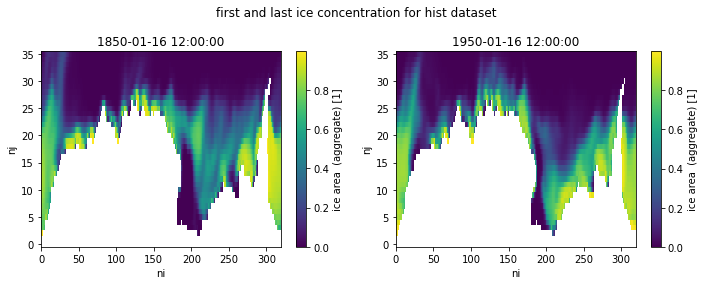

In [16]:
# check that this data looks reasonable

mem_5_hist = ds_hist.aice.isel(member_id=5)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 4))

mem_5_hist.isel(time=0).plot(ax=ax1)
ax1.set_title(mem_5_hist.isel(time=0).time.values)

mem_5_hist.isel(time=1200).plot(ax=ax2)
ax2.set_title(mem_5_hist.isel(time=1200).time.values)

fig.suptitle("first and last ice concentration for hist dataset")

plt.tight_layout()
plt.show()

### Load future data

In [17]:
%%time
# load future
ds_ssp = load_datasets(varnames, 'ssp370',lat_min,lat_max)
ds_ssp


--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream.forcing_variant.variable'


CPU times: user 8.82 s, sys: 190 ms, total: 9.01 s
Wall time: 11.3 s


<xarray.Dataset>
Dimensions:      (nj: 36, ni: 320, time: 1032, d2: 2, member_id: 50)
Coordinates:
    TLON         (nj, ni) float32 dask.array<chunksize=(36, 320), meta=np.ndarray>
    TLAT         (nj, ni) float32 dask.array<chunksize=(36, 320), meta=np.ndarray>
  * time         (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
Dimensions without coordinates: nj, ni, d2, member_id
Data variables:
    tarea        (nj, ni) float32 dask.array<chunksize=(36, 320), meta=np.ndarray>
    time_bounds  (time, d2, nj, ni) object dask.array<chunksize=(120, 2, 36, 320), meta=np.ndarray>
    aice         (member_id, time, nj, ni) float32 dask.array<chunksize=(1, 120, 36, 320), meta=np.ndarray>
Attributes:
    history:                 This dataset was created on 2020-04-29 at 18:54\...
    time_period_freq:        month_1
    intake_esm_varname:      ['aice']
    comment:                 All years have exactly 365 days
    conventions:             CF-1.0
    comment3:                seconds elapsed into model date:      0
    contents:                Diagnostic and Prognostic Variables
    source:                  Los Alamos Sea Ice Model (CICE) Version 5
    comment2:                File written on model date 20950201
    io_flavor:               io_pio
    model_doi_url:           https://doi.org/10.5065/D67H1H0V
    intake_esm_dataset_key:  ice.ssp370.cice.h.cmip6.aice

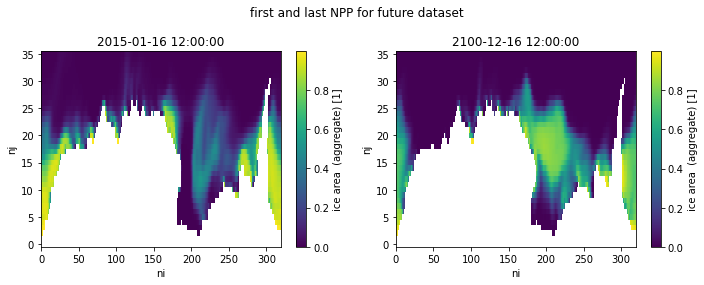

In [18]:
# check that this data looks reasonable

mem_5_ssp = ds_ssp.aice.isel(member_id=5)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 4))

mem_5_ssp.isel(time=0).plot(ax=ax1)
ax1.set_title(mem_5_ssp.isel(time=0).time.values)

mem_5_ssp.isel(time=-1).plot(ax=ax2)
ax2.set_title(mem_5_ssp.isel(time=-1).time.values)

fig.suptitle("first and last NPP for future dataset")

plt.tight_layout()
plt.show()

## Concatenate historical and future datasets and crop to just the times we need


In [19]:
ds = xr.concat((ds_hist, ds_ssp),dim='time')
ds.time

<xarray.DataArray 'time' (time: 3012)>
array([cftime.DatetimeNoLeap(1850, 1, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1850, 2, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1850, 3, 16, 12, 0, 0, 0, has_year_zero=True),
       ...,
       cftime.DatetimeNoLeap(2100, 10, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2100, 11, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2100, 12, 16, 12, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 1850-01-16 12:00:00 ... 2100-12-16 12:00:00

In [20]:
# keep just years chosen above
ds = ds.sel(time=slice(yy_st, yy_ed))
#ds = ds.isel(time=slice(1200, 3012)) # Cut timeseries to 1950 - 2100: 1812 time steps
ds.time

<xarray.DataArray 'time' (time: 1812)>
array([cftime.DatetimeNoLeap(1950, 1, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1950, 2, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1950, 3, 16, 12, 0, 0, 0, has_year_zero=True),
       ...,
       cftime.DatetimeNoLeap(2100, 10, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2100, 11, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2100, 12, 16, 12, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 1950-01-16 12:00:00 ... 2100-12-16 12:00:00

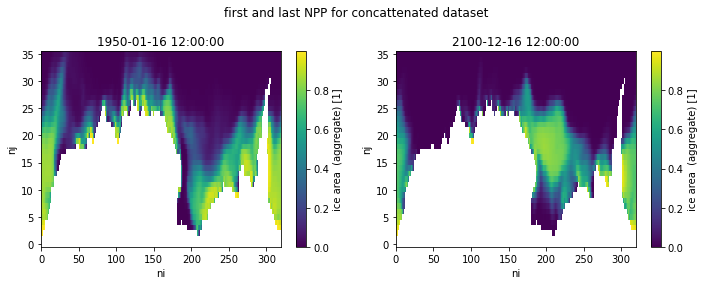

In [21]:
# check that this data looks reasonable

mem_5 = ds.aice.isel(member_id=5)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 4))

mem_5.isel(time=0).plot(ax=ax1)
ax1.set_title(mem_5.isel(time=0).time.values)

mem_5.isel(time=-1).plot(ax=ax2)
ax2.set_title(mem_5.isel(time=-1).time.values)

fig.suptitle("first and last NPP for concattenated dataset")

plt.tight_layout()
plt.show()

# Compute Annual Maximum SIE
* Maximum extent is either in September or October

In [22]:
# get some sizes
years = np.arange(int(yy_st),int(yy_ed),1)

tlen = 150 #annual timesteps 
xlen = len(ds.ni)
ylen = len(ds.nj)
elen = len(ds.member_id)
print(tlen,xlen,ylen,elen)

variable = 'aice'

150 320 36 50


### Get the September and October sea ice

In [23]:
%%time

var = variable

ds_Sep = xr.Dataset()
Sep = np.zeros([tlen,elen,ylen,xlen])

ds_Oct = xr.Dataset()
Oct = np.zeros([tlen,elen,ylen,xlen])

ds_Sep_Oct = xr.Dataset()
Sep_Oct = np.zeros([tlen,elen,ylen,xlen])

for year in np.arange(0,150,1):

    # September
    #get time index of september for this year
    st_mon_sep = year*12 + 8
    #get that month only
    Sep[year,:,:,:] = ds[var].isel(time=st_mon_sep)

    # October
    #get time index of september for this year
    st_mon_oct = year*12 + 9
    #get that month only
    Oct[year,:,:,:] = ds[var].isel(time=st_mon_oct)

    # Sept and Oct mean
    #get those months only
    temp = ds[var].isel(time=slice(st_mon_sep,st_mon_oct+1))
    Sep_Oct[year,:,:,:] = temp.mean(dim='time')

# turn into xarrays
Sep = xr.DataArray(Sep,dims=('time','member_id','nlat','nlon'))
ds_Sep[var] = Sep
ds_Sep[var].attrs['units'] = ''
ds_Sep['time'] = years

Oct = xr.DataArray(Oct,dims=('time','member_id','nlat','nlon'))
ds_Oct[var] = Oct
ds_Oct[var].attrs['units'] = ''
ds_Oct['time'] = years

Sep_Oct = xr.DataArray(Sep_Oct,dims=('time','member_id','nlat','nlon'))
ds_Sep_Oct[var] = Sep_Oct
ds_Sep_Oct[var].attrs['units'] = ''
ds_Sep_Oct['time'] = years

CPU times: user 2min 15s, sys: 7.2 s, total: 2min 22s
Wall time: 5min 5s


### Calculate the SIA each year

In [24]:
# keep only regions with >15% ice cover
ds_Sep_mask = ds_Sep.where(ds_Sep.aice > 0.15)
ds_Oct_mask = ds_Oct.where(ds_Oct.aice > 0.15)
ds_Sep_Oct_mask = ds_Sep_Oct.where(ds_Sep_Oct.aice > 0.15)

In [25]:
ds_Sep_mask['time'] = years
ds_Oct_mask['time'] = years
ds_Sep_Oct_mask['time'] = years

In [26]:
# multipy by tarea
tarea = ds.tarea.isel(time=0)
tarea = tarea.rename({'nj':'nlat','ni': 'nlon'})

ds_Sep_mask = ds_Sep_mask*tarea
ds_Oct_mask = ds_Oct_mask*tarea
ds_Sep_Oct_mask = ds_Sep_Oct_mask*tarea

In [27]:
# sum over all lat/lon points
ds_Sep_sum = ds_Sep_mask.aice.sum(dim=['nlat','nlon'])
ds_Oct_sum = ds_Oct_mask.aice.sum(dim=['nlat','nlon'])
ds_Sep_Oct_sum = ds_Sep_Oct_mask.aice.sum(dim=['nlat','nlon'])

In [28]:
# get ensemble mean and standard deviations
ds_Sep_avg = ds_Sep_sum.mean(dim='member_id')
ds_Sep_std = ds_Sep_sum.std(dim='member_id')
ds_Oct_avg = ds_Oct_sum.mean(dim='member_id')
ds_Oct_std = ds_Oct_sum.std(dim='member_id')
ds_Sep_Oct_avg = ds_Sep_Oct_sum.mean(dim='member_id')
ds_Sep_Oct_std = ds_Sep_Oct_sum.std(dim='member_id')

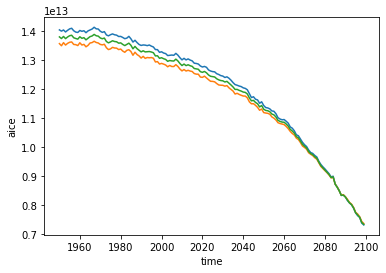

In [29]:
ds_Sep_avg.plot()
ds_Oct_avg.plot()
ds_Sep_Oct_avg.plot()

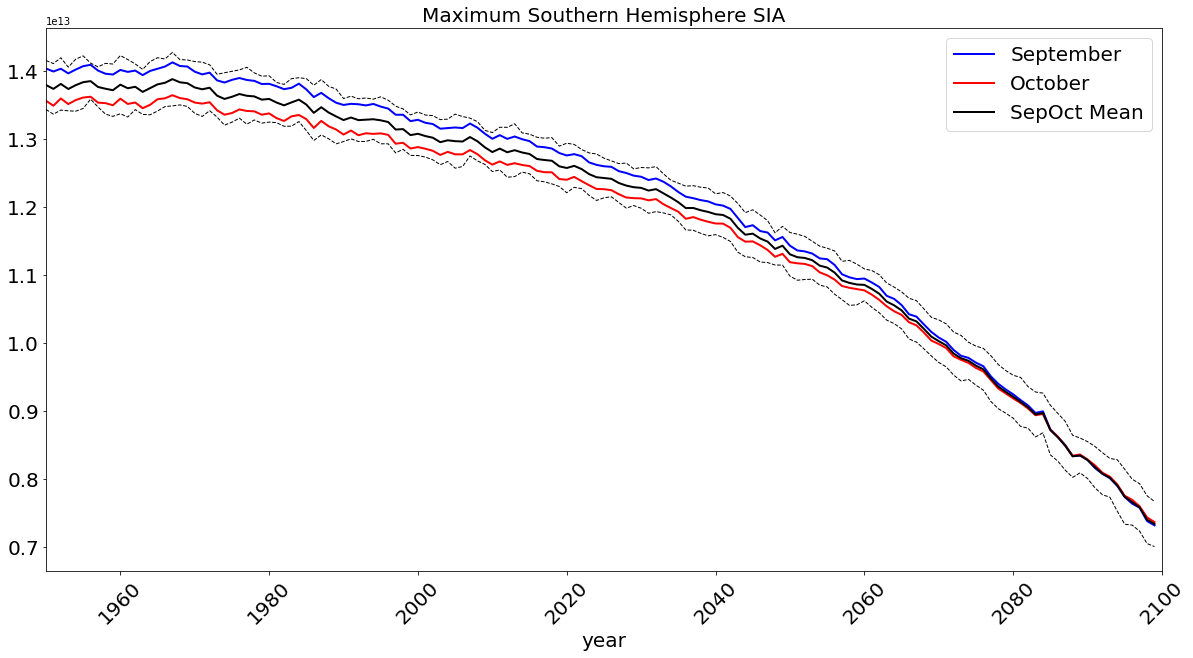

In [30]:
# Make nicer plot with standard deviations

# create figure
fig = plt.figure(figsize=(20,10))

# Make subplot - note it's nrow x ncol x index (starting upper left)
ax = fig.add_subplot(1,1,1) 

# plot the Sep values
ax.plot(years,ds_Sep_avg,label="September",color='blue',linestyle='solid',linewidth=2)
#ax.plot(years,ds_Sep_avg+ds_Sep_std,color='blue',linestyle='dashed',linewidth=1)
#ax.plot(years,ds_Sep_avg-ds_Sep_std,color='blue',linestyle='dashed',linewidth=1)

# plot the Oct values
ax.plot(years,ds_Oct_avg,label="October",color='red',linestyle='solid',linewidth=2)
#ax.plot(years,ds_Oct_avg+ds_Oct_std,color='red',linestyle='dashed',linewidth=1)
#ax.plot(years,ds_Oct_avg-ds_Oct_std,color='red',linestyle='dashed',linewidth=1)

# plot the mean Sep/Oct values
ax.plot(years,ds_Sep_Oct_avg,label="SepOct Mean",color='black',linestyle='solid',linewidth=2)
ax.plot(years,ds_Sep_Oct_avg+ds_Sep_Oct_std,color='black',linestyle='dashed',linewidth=1)
ax.plot(years,ds_Sep_Oct_avg-ds_Sep_Oct_std,color='black',linestyle='dashed',linewidth=1)

# finish up plot
plt.title('Maximum Southern Hemisphere SIA',fontsize=20)
plt.xlabel('year',fontsize=20)
plt.xticks(fontsize=20, rotation=45)
plt.xlim([1950,2100])
plt.yticks(fontsize=20)
plt.legend(ncol=1,fontsize=20)


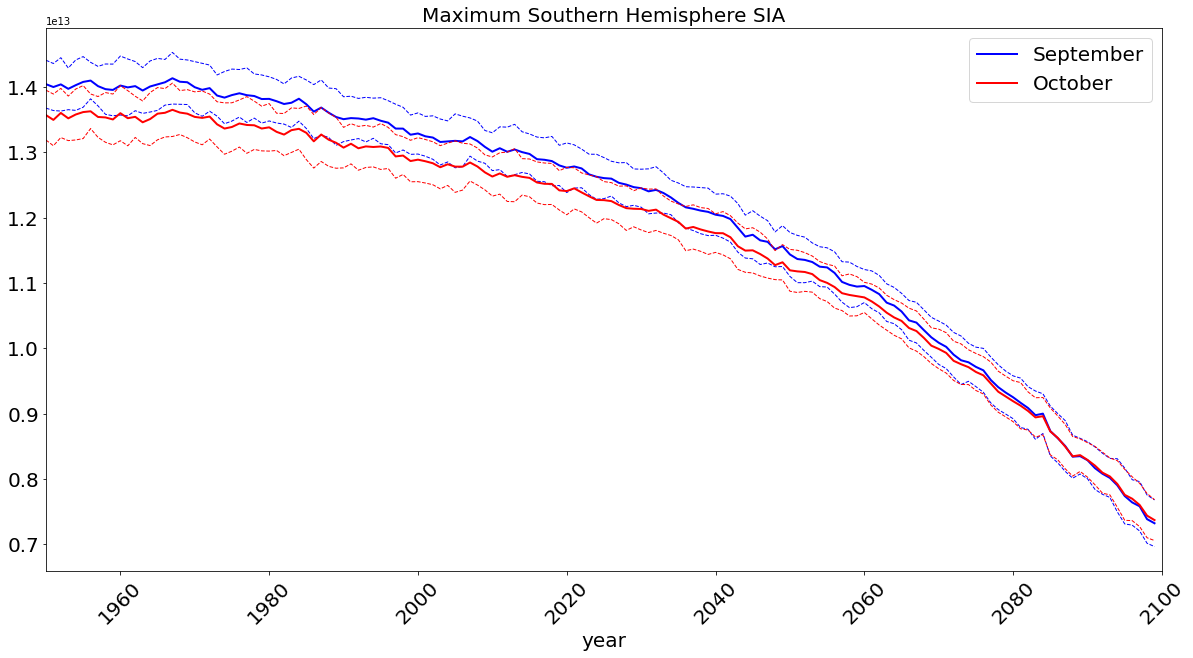

In [31]:
# Make nicer plot with standard deviations

# create figure
fig = plt.figure(figsize=(20,10))

# Make subplot - note it's nrow x ncol x index (starting upper left)
ax = fig.add_subplot(1,1,1) 

# plot the Sep values
ax.plot(years,ds_Sep_avg,label="September",color='blue',linestyle='solid',linewidth=2)
ax.plot(years,ds_Sep_avg+ds_Sep_std,color='blue',linestyle='dashed',linewidth=1)
ax.plot(years,ds_Sep_avg-ds_Sep_std,color='blue',linestyle='dashed',linewidth=1)

# plot the Oct values
ax.plot(years,ds_Oct_avg,label="October",color='red',linestyle='solid',linewidth=2)
ax.plot(years,ds_Oct_avg+ds_Oct_std,color='red',linestyle='dashed',linewidth=1)
ax.plot(years,ds_Oct_avg-ds_Oct_std,color='red',linestyle='dashed',linewidth=1)

# finish up plot
plt.title('Maximum Southern Hemisphere SIA',fontsize=20)
plt.xlabel('year',fontsize=20)
plt.xticks(fontsize=20, rotation=45)
plt.xlim([1950,2100])
plt.yticks(fontsize=20)
plt.legend(ncol=1,fontsize=20)


- Satellite observations show maximum sea ice extent in September, but past work showed CESM2 maximum in October (DuVivier et al. 2020, https://doi.org/10.1029/2019JC015934).
- The above figures show that in the CESM2-LE the September sea ice area is greater than the October sea ice area. Time indices have been checked to verify we're pulling the correct months.
- This result is contrary to the DuVivier 2020 paper, but does match observations better.
- Therefore, for calculation of yearly SIZ we will use CESM2-LE September sea ice concentrations.

## Calculate SIZ

### Load CESM2-LE ocean grid

In [32]:
# directory path
dir_in = '/glade/campaign/cgd/ppc/duvivier/masks/'

In [33]:
# load ocean grid
fin = 'ocn_grid.nc'
ds_grid = xr.open_mfdataset(dir_in+fin,decode_times=False)
ds_grid['nlat'] = ds_grid.nlat
ds_grid['nlon'] = ds_grid.nlon
ds_grid

<xarray.Dataset>
Dimensions:                 (moc_comp: 3, transport_comp: 5, transport_reg: 2, z_t: 60, z_t_150m: 15, z_w: 60, z_w_top: 60, z_w_bot: 60, lat_aux_grid: 395, moc_z: 61, nlat: 384, nlon: 320, time: 1188, d2: 2)
Coordinates: (12/14)
  * z_t                     (z_t) float32 500.0 1.5e+03 ... 5.125e+05 5.375e+05
  * z_t_150m                (z_t_150m) float32 500.0 1.5e+03 ... 1.45e+04
  * z_w                     (z_w) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
  * z_w_top                 (z_w_top) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
  * z_w_bot                 (z_w_bot) float32 1e+03 2e+03 ... 5.25e+05 5.5e+05
  * lat_aux_grid            (lat_aux_grid) float32 -79.49 -78.95 ... 89.47 90.0
    ...                      ...
    ULAT                    (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLONG                   (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLAT                    (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
  * time                    (time) float32 31.0 59.0 90.0 ... 3.61e+04 3.614e+04
  * nlat                    (nlat) int64 0 1 2 3 4 5 ... 378 379 380 381 382 383
  * nlon                    (nlon) int64 0 1 2 3 4 5 ... 314 315 316 317 318 319
Dimensions without coordinates: moc_comp, transport_comp, transport_reg, d2
Data variables: (12/58)
    moc_components          (moc_comp) |S384 dask.array<chunksize=(3,), meta=np.ndarray>
    transport_components    (transport_comp) |S384 dask.array<chunksize=(5,), meta=np.ndarray>
    transport_regions       (transport_reg) |S384 dask.array<chunksize=(2,), meta=np.ndarray>
    dz                      (z_t) float32 dask.array<chunksize=(60,), meta=np.ndarray>
    dzw                     (z_w) float32 dask.array<chunksize=(60,), meta=np.ndarray>
    KMT                     (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ...                      ...
    nsurface_u              float64 ...
    time_bound              (time, d2) float64 dask.array<chunksize=(1188, 2), meta=np.ndarray>
    QFLUX                   (time, nlat, nlon) float32 dask.array<chunksize=(1188, 384, 320), meta=np.ndarray>
    SHF                     (time, nlat, nlon) float32 dask.array<chunksize=(1188, 384, 320), meta=np.ndarray>
    SHF_QSW                 (time, nlat, nlon) float32 dask.array<chunksize=(1188, 384, 320), meta=np.ndarray>
    TEMP                    (time, z_t, nlat, nlon) float32 dask.array<chunksize=(1188, 60, 384, 320), meta=np.ndarray>
Attributes:
    title:             b.e21.B1850.f09_g17.CMIP6-piControl.001
    history:           none
    Conventions:       CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-cu...
    time_period_freq:  month_1
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    contents:          Diagnostic and Prognostic Variables
    source:            CCSM POP2, the CCSM Ocean Component
    revision:          $Id: tavg.F90 89644 2018-08-04 14:26:01Z klindsay $
    calendar:          All years have exactly  365 days.
    start_time:        This dataset was created on 2018-08-09 at 18:18:26.3
    cell_methods:      cell_methods = time: mean ==> the variable values are ...

In [34]:
# load sea ice masks
fin = 'REGION_MASK_gx1v7.nc'
ds_mask = xr.open_mfdataset(dir_in+fin,decode_times=False)
ds_mask = ds_mask.isel(time=0)
ds_mask = ds_mask.rename({'lat':'nlat','lon': 'nlon'})
ds_mask['nlat'] = ds_grid.nlat
ds_mask['nlon'] = ds_grid.nlon
ds_mask

<xarray.Dataset>
Dimensions:       (nlon: 320, nlat: 384)
Coordinates:
  * nlon          (nlon) int64 0 1 2 3 4 5 6 7 ... 313 314 315 316 317 318 319
  * nlat          (nlat) int64 0 1 2 3 4 5 6 7 ... 377 378 379 380 381 382 383
Data variables: (12/18)
    Lab_mask      (nlat, nlon) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
    GIN_mask      (nlat, nlon) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
    Bar_mask      (nlat, nlon) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ArcOc_mask    (nlat, nlon) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
    Sib_mask      (nlat, nlon) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
    Beau_mask     (nlat, nlon) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ...            ...
    Ross_mask     (nlat, nlon) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
    Ind_mask      (nlat, nlon) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
    Pac_mask      (nlat, nlon) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
    BAm_mask      (nlat, nlon) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
    nh_mask       (nlat, nlon) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
    sh_mask       (nlat, nlon) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>

In [35]:
# crop data to the latitudes we want, use given lat/lon, not specific indices
ds_grid = ds_grid.where(((ds_grid['TLAT'] <= lat_max) & (ds_grid['TLAT'] >= lat_min)), drop=True)
ds_mask = ds_mask.where(((ds_grid['TLAT'] <= lat_max) & (ds_grid['TLAT'] >= lat_min)), drop=True)

### Make SIZ masks

In [36]:
# set some coordinates for the sea ice so we can do the masking
ds_Sep['nlat'] = ds_mask.nlat
ds_Sep['nlon'] = ds_mask.nlon

In [37]:
# create a mask using the 0-1 array from sh_mask and where SIC is above 15%
SIZ_mask = ds_mask.sh_mask.where(ds_Sep.aice >= 0.15,0)

# omit land points
SIZ_mask = SIZ_mask.where(ds_grid.REGION_MASK == 1)

SIZ_mask

<xarray.DataArray 'sh_mask' (nlat: 36, nlon: 320, time: 150, member_id: 50)>
dask.array<where, shape=(36, 320, 150, 50), dtype=float32, chunksize=(36, 320, 150, 50), chunktype=numpy.ndarray>
Coordinates:
  * nlat     (nlat) int64 0 1 2 3 4 5 6 7 8 9 ... 26 27 28 29 30 31 32 33 34 35
  * nlon     (nlon) int64 0 1 2 3 4 5 6 7 8 ... 312 313 314 315 316 317 318 319
    ULONG    (nlat, nlon) float64 321.1 322.3 323.4 324.5 ... 317.8 318.9 320.0
    ULAT     (nlat, nlon) float64 -78.95 -78.95 -78.95 ... -60.25 -60.25 -60.25
    TLONG    (nlat, nlon) float64 320.6 321.7 322.8 323.9 ... 317.2 318.3 319.4
    TLAT     (nlat, nlon) float64 -79.22 -79.22 -79.22 ... -60.52 -60.52 -60.52
  * time     (time) int64 1950 1951 1952 1953 1954 ... 2095 2096 2097 2098 2099
Dimensions without coordinates: member_id

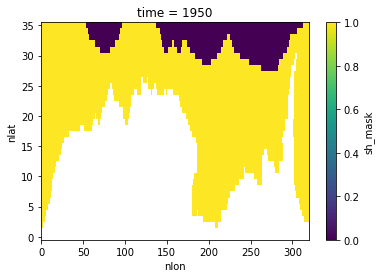

In [38]:
SIZ_mask.isel(time=0,member_id=0).plot()

## Put together into one dataset

- Netcdf with variable dimension: (member_id x year x nlat x nlon) Include TLAT and TLONG as coordinates

In [39]:
ds_out = xr.Dataset()

ds_out['SIC_SEP'] = ds_Sep[variable]
ds_out['SIZ_SEP'] = SIZ_mask

# change the attributes
ds_out.attrs['author'] = 'Alice DuVivier'
ds_out.attrs['date_processed'] = datetime.now().strftime('%Y-%m-%d')
ds_out.attrs['contents'] = f'September {variable} in the Southern Ocean from 1950 to 2099. SIZ is defined as maximum sea ice extent in a year.'

ds_out

<xarray.Dataset>
Dimensions:  (nlon: 320, nlat: 36, time: 150, member_id: 50)
Coordinates:
  * nlon     (nlon) int64 0 1 2 3 4 5 6 7 8 ... 312 313 314 315 316 317 318 319
  * nlat     (nlat) int64 0 1 2 3 4 5 6 7 8 9 ... 26 27 28 29 30 31 32 33 34 35
  * time     (time) int64 1950 1951 1952 1953 1954 ... 2095 2096 2097 2098 2099
    ULONG    (nlat, nlon) float64 321.1 322.3 323.4 324.5 ... 317.8 318.9 320.0
    ULAT     (nlat, nlon) float64 -78.95 -78.95 -78.95 ... -60.25 -60.25 -60.25
    TLONG    (nlat, nlon) float64 320.6 321.7 322.8 323.9 ... 317.2 318.3 319.4
    TLAT     (nlat, nlon) float64 -79.22 -79.22 -79.22 ... -60.52 -60.52 -60.52
Dimensions without coordinates: member_id
Data variables:
    SIC_SEP  (time, member_id, nlat, nlon) float64 nan nan nan ... 0.0 0.0 0.0
    SIZ_SEP  (nlat, nlon, time, member_id) float32 dask.array<chunksize=(36, 320, 150, 50), meta=np.ndarray>
Attributes:
    author:          Alice DuVivier
    date_processed:  2024-01-26
    contents:        September aice in the Southern Ocean from 1950 to 2099. ...

In [40]:
# Print the dimensions
print("Dimensions:")
for dim in ds_out.dims:
    print(f"\t{dim}: {ds_out[dim].values.shape}")

# Print the coordinates
print("Coordinates:")
for coord in ds_out.coords:
    print(f"\t{coord}:")
    print(f"\t\t{ds_out.coords[coord].values}")
    
# Print the attributes
print("Attributes:")
for attr in ds_out.attrs:
    print(f"\t{attr}: {ds_out.attrs[attr]}")
    

Dimensions:
	nlon: (320,)
	nlat: (36,)
	time: (150,)
	member_id: (50,)
Coordinates:
	nlon:
		[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 22

## Export and Save

In [41]:
# calculate the size of the dataset in GB
size_gb = ds_out.nbytes / (1024**3)
print(f"The dataset is approximately {size_gb:.2f} GB.")


The dataset is approximately 0.97 GB.


In [42]:
path_out = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/DATA/ecoindex_data/seaice/'
file_out = 'CESM2-LE-SIZ_SIC.nc'
fout = path_out + file_out

In [43]:
# Export the dataset to NetCDF with all attributes and coordinates
ds_out.to_netcdf(fout)

In [44]:
cluster.close()

## Test if it worked

In [45]:
import netCDF4
nc = netCDF4.Dataset(fout)
print(nc.variables)

{'nlon': <class 'netCDF4._netCDF4.Variable'>
int64 nlon(nlon)
unlimited dimensions: 
current shape = (320,)
filling on, default _FillValue of -9223372036854775806 used, 'nlat': <class 'netCDF4._netCDF4.Variable'>
int64 nlat(nlat)
unlimited dimensions: 
current shape = (36,)
filling on, default _FillValue of -9223372036854775806 used, 'time': <class 'netCDF4._netCDF4.Variable'>
int64 time(time)
unlimited dimensions: 
current shape = (150,)
filling on, default _FillValue of -9223372036854775806 used, 'SIC_SEP': <class 'netCDF4._netCDF4.Variable'>
float64 SIC_SEP(time, member_id, nlat, nlon)
    _FillValue: nan
    units: 
    coordinates: ULAT TLONG TLAT ULONG
unlimited dimensions: 
current shape = (150, 50, 36, 320)
filling on, 'ULONG': <class 'netCDF4._netCDF4.Variable'>
float64 ULONG(nlat, nlon)
    _FillValue: nan
    long_name: array of u-grid longitudes
    units: degrees_east
unlimited dimensions: 
current shape = (36, 320)
filling on, 'ULAT': <class 'netCDF4._netCDF4.Variable'>
f

In [46]:
path =  path_out
ds_in =  xr.open_dataset(path_out+file_out, decode_times=True)

In [47]:
ds_in.info()

xarray.Dataset {
dimensions:
	nlon = 320 ;
	nlat = 36 ;
	time = 150 ;
	member_id = 50 ;

variables:
	int64 nlon(nlon) ;
	int64 nlat(nlat) ;
	int64 time(time) ;
	float64 SIC_SEP(time, member_id, nlat, nlon) ;
		SIC_SEP:units =  ;
	float64 ULONG(nlat, nlon) ;
		ULONG:long_name = array of u-grid longitudes ;
		ULONG:units = degrees_east ;
	float64 ULAT(nlat, nlon) ;
		ULAT:long_name = array of u-grid latitudes ;
		ULAT:units = degrees_north ;
	float64 TLONG(nlat, nlon) ;
		TLONG:long_name = array of t-grid longitudes ;
		TLONG:units = degrees_east ;
	float64 TLAT(nlat, nlon) ;
		TLAT:long_name = array of t-grid latitudes ;
		TLAT:units = degrees_north ;
	float32 SIZ_SEP(nlat, nlon, time, member_id) ;

// global attributes:
	:author = Alice DuVivier ;
	:date_processed = 2024-01-26 ;
	:contents = September aice in the Southern Ocean from 1950 to 2099. SIZ is defined as maximum sea ice extent in a year. ;
}

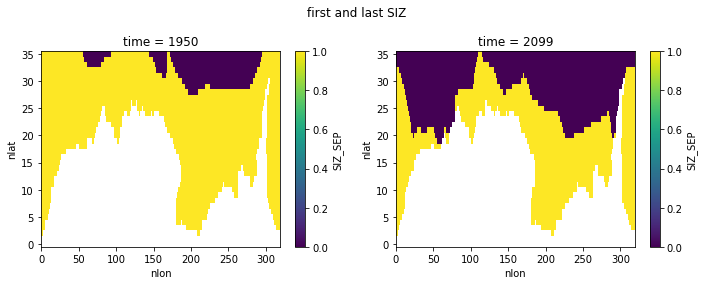

In [49]:
mem_5_ints = ds_in.SIZ_SEP.isel(member_id=5)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 4))

mem_5_ints.isel(time=0).plot(ax=ax1)

mem_5_ints.isel(time=-1).plot(ax=ax2)

fig.suptitle("first and last SIZ")

plt.tight_layout()
plt.show()